# **Twitter Sentiment Analysis using Spark & Hadoop**

### **Collaborators**
- Ahmed Abdullah
- Ibtehaj Alvi

In [1]:
!pip install pyspark
!pip install spark-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=29bc2116276a57ce3e6c534de3412743ce82af9befab459a4aefa0f77b005332
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.4/568.4 kB 13.1 MB/s eta 0:00:00


### **Necessary Libraries**

In [76]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import HashingTF, IDF
from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import DoubleType, StringType
from pyspark.ml.feature import StringIndexer

import nltk
nltk.download('wordnet')
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from nltk.stem import WordNetLemmatizer

# Models
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.classification import NaiveBayes

from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **Spark Session**

In [40]:
spark = SparkSession.builder \
    .appName("Twitter Analysis") \
    .getOrCreate()

### **Spark DataFrame**

In [41]:
df = spark.read.csv("Sentiment.csv", header=True, inferSchema=True)

In [42]:
columns_to_keep = ['sentiment', 'sentiment_confidence', 'text']

df = df[columns_to_keep]
df.show(10)

+--------------------+--------------------+--------------------+
|           sentiment|sentiment_confidence|                text|
+--------------------+--------------------+--------------------+
|            Positive|                   1|RT @RobGeorge: Th...|
|             Neutral|                   1|Going on #MSNBC L...|
|            Negative|                   1|@JGreenDC @realDo...|
|            Positive|                   1|RT @WayneDupreeSh...|
|Central Time (US ...|                NULL|                NULL|
|            Positive|                   1|RT @pattonoswalt:...|
|            Negative|                   1|Hey @ChrisChristi...|
|            Negative|                   1|reason comment is...|
|            Positive|                   1|RT @ChuckNellis: ...|
|            Negative|                   1|RT @erinmallorylo...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



In [43]:
df = df.withColumn("sentiment_confidence", df["sentiment_confidence"].cast(DoubleType()))

In [44]:
df.printSchema()

root
 |-- sentiment: string (nullable = true)
 |-- sentiment_confidence: double (nullable = true)
 |-- text: string (nullable = true)



In [45]:
df.count()

16032

In [46]:
min_max_confidence = df.selectExpr("min(sentiment_confidence) as min_confidence", "max(sentiment_confidence) as max_confidence").first()

min_confidence = min_max_confidence.min_confidence
max_confidence = min_max_confidence.max_confidence

print(f"Min. Confidence: {min_confidence}")

Min. Confidence: 0.186


### **Dropping Nulls, Retweets & Duplicate**

In [47]:
df = df.na.drop()
df = df.dropDuplicates()

In [48]:
df = df.filter(~df['text'].startswith('RT'))
df = df.filter(~df['text'].startswith('"RT'))
df = df.filter((df['sentiment_confidence'] > 0.5) & (df['sentiment_confidence'] <= 1))

df.show(5)

+---------+--------------------+--------------------+
|sentiment|sentiment_confidence|                text|
+---------+--------------------+--------------------+
|  Neutral|                 1.0|#GOPDebate consta...|
| Negative|                 1.0|"""@RubinReport: ...|
| Negative|                 1.0|#GOPDebate @JohnK...|
|  Neutral|                 1.0|"Fox News was the...|
| Negative|                 1.0|@realDonaldTrump ...|
+---------+--------------------+--------------------+
only showing top 5 rows



In [49]:
def remove_links_and_at_words(text):
    words = text.split()
    cleaned_words = [word for word in words if '@' not in word and 'http://' not in word and 'https://' not in word]
    return ' '.join(cleaned_words)

remove_links_and_at_words_udf = udf(remove_links_and_at_words, StringType())

df = df.withColumn('text', remove_links_and_at_words_udf(df['text']))

df.show(5)

+---------+--------------------+--------------------+
|sentiment|sentiment_confidence|                text|
+---------+--------------------+--------------------+
|  Neutral|                 1.0|#GOPDebate consta...|
| Negative|                 1.0|Finally got it. T...|
| Negative|                 1.0|#GOPDebate your c...|
|  Neutral|                 1.0|"Fox News was the...|
| Negative|                 1.0|is a breath of fr...|
+---------+--------------------+--------------------+
only showing top 5 rows



In [50]:
df.count()

5403

### Plotting the Univariate Distribution of Sentiments

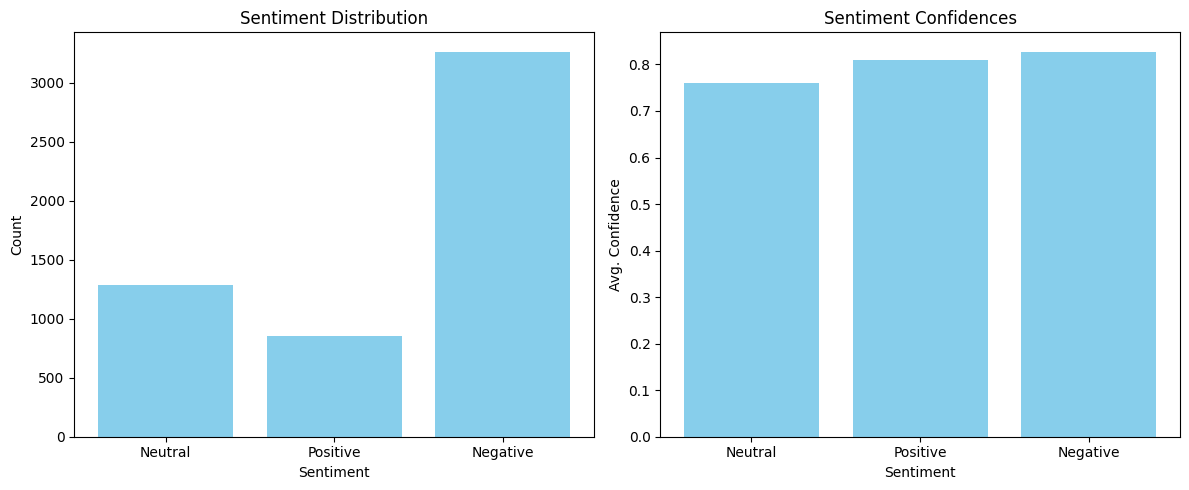

In [51]:
sentiment_counts = df.groupBy('sentiment').count()
sentiment_counts_pd = sentiment_counts.toPandas()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(sentiment_counts_pd['sentiment'], sentiment_counts_pd['count'], color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')

avg_sentimental_confidence = df.groupBy('sentiment').avg('sentiment_confidence')
sentiment_counts_pd = avg_sentimental_confidence.toPandas()

plt.subplot(1, 2, 2)
plt.bar(sentiment_counts_pd['sentiment'], sentiment_counts_pd['avg(sentiment_confidence)'], color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Avg. Confidence')
plt.title('Sentiment Confidences')

plt.tight_layout()
plt.show()

### **Preprocessing Pipeline**


In [52]:
class Lemmatizer(Transformer):
    def __init__(self, inputCol, outputCol):
        self.inputCol = inputCol
        self.outputCol = outputCol
        self.lemmatizer = WordNetLemmatizer()

    def _transform(self, df):
        lemmatize_udf = udf(lambda tokens: [self.lemmatizer.lemmatize(token) for token in tokens], ArrayType(StringType()))
        return df.withColumn(self.outputCol, lemmatize_udf(df[self.inputCol]))

# Define preprocessing stages
tokenizer = RegexTokenizer(inputCol="text", outputCol="tokens", pattern="\\W")
additional_stop_words = ['gopdebate', 'gopdebates', 'last', 'night', 'candidate', 'candidates']
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=additional_stop_words)
lemmatizer = Lemmatizer(inputCol="filtered_tokens", outputCol="lemmatized_tokens")
count_vectorizer = CountVectorizer(inputCol="lemmatized_tokens", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

pipeline = Pipeline(stages=[tokenizer, stopwords_remover, lemmatizer, count_vectorizer, idf])

pipeline_model = pipeline.fit(df)

preprocessed_df = pipeline_model.transform(df)


In [53]:
df = preprocessed_df.select('sentiment', 'features')

df.show(truncate=False)

+---------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sentiment|features                                                                                                                                                                                                                                                                                                                                                                                                                                              |
+---------+---------------------------------------------------------------------------------------

### **Word Cloud**

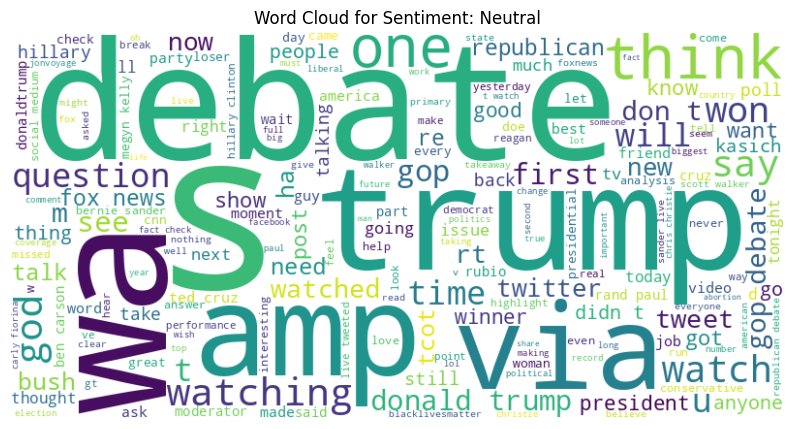

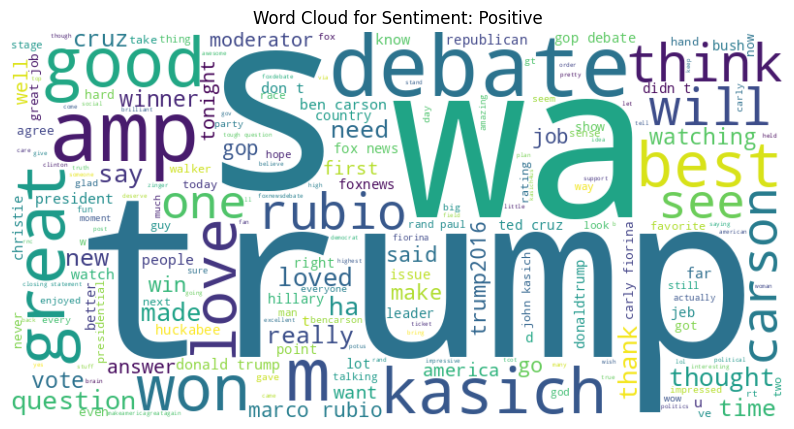

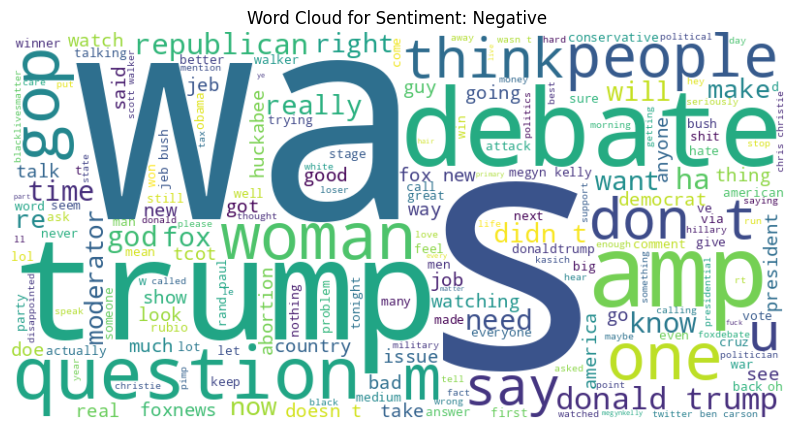

In [54]:
def generate_word_cloud(sentiment_category):
    tokens_by_sentiment = preprocessed_df.filter(preprocessed_df["sentiment"] == sentiment_category).select("lemmatized_tokens")

    lemmatized_tokens = tokens_by_sentiment.rdd.flatMap(lambda x: x[0])

    token_list = lemmatized_tokens.collect()

    text = " ".join(token_list)

    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title("Word Cloud for Sentiment: " + sentiment_category)
    plt.axis("off")
    plt.show()

sentiment_categories = preprocessed_df.select("sentiment").distinct().rdd.flatMap(lambda x: x).collect()
for sentiment_category in sentiment_categories:
    generate_word_cloud(sentiment_category)


### **Label Encoder for Sentiments**

In [55]:
sentiment_indexer = StringIndexer(inputCol="sentiment", outputCol="indexed_sentiment")

indexer_model = sentiment_indexer.fit(df)

df = indexer_model.transform(df)

df.show()

+---------+--------------------+-----------------+
|sentiment|            features|indexed_sentiment|
+---------+--------------------+-----------------+
|  Neutral|(7577,[1,2,9,14,1...|              1.0|
| Negative|(7577,[9,10,27,32...|              0.0|
| Negative|(7577,[15,62,96,1...|              0.0|
|  Neutral|(7577,[0,2,4,9,16...|              1.0|
| Negative|(7577,[0,1,2,4,5,...|              0.0|
| Negative|(7577,[0,1,8,11,1...|              0.0|
| Negative|(7577,[0,2,15,16,...|              0.0|
| Positive|(7577,[1,2,5,7,9,...|              2.0|
| Negative|(7577,[9,10,18,26...|              0.0|
| Negative|(7577,[1,6,82,123...|              0.0|
| Negative|(7577,[0,1,2,5,33...|              0.0|
| Negative|(7577,[6,302,550,...|              0.0|
| Negative|(7577,[8,13,41,93...|              0.0|
| Negative|(7577,[5,14,29,18...|              0.0|
| Negative|(7577,[1,7,32,177...|              0.0|
| Negative|(7577,[0,71,128,3...|              0.0|
| Negative|(7577,[0,4,5,17,2...

### **Applying '*Logistic Regression* '**

Accuracy: 0.5819672131147541
Precision: 0.6173878273196621


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


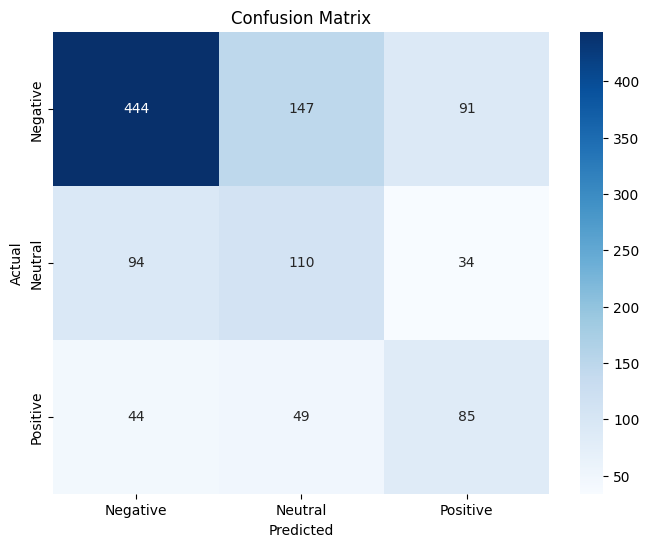

In [72]:
lr = LogisticRegression(featuresCol='features', labelCol='indexed_sentiment')

train_df, test_df = df.randomSplit([0.8, 0.2], seed=69)

lr_model = lr.fit(train_df)

predictions = lr_model.transform(test_df)

accuracy_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_sentiment", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
log_acc = accuracy
print("Accuracy:", accuracy)

precision_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_sentiment", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
log_prec = precision
print("Precision:", precision)

prediction_and_label = predictions.select("prediction", "indexed_sentiment").rdd.map(tuple)

metrics = MulticlassMetrics(prediction_and_label)

confusion_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **Applying '*Linear Regression* ' 💀**

Root Mean Squared Error (RMSE): 2.1626923327165835
R-squared value: 0.9756739621025826


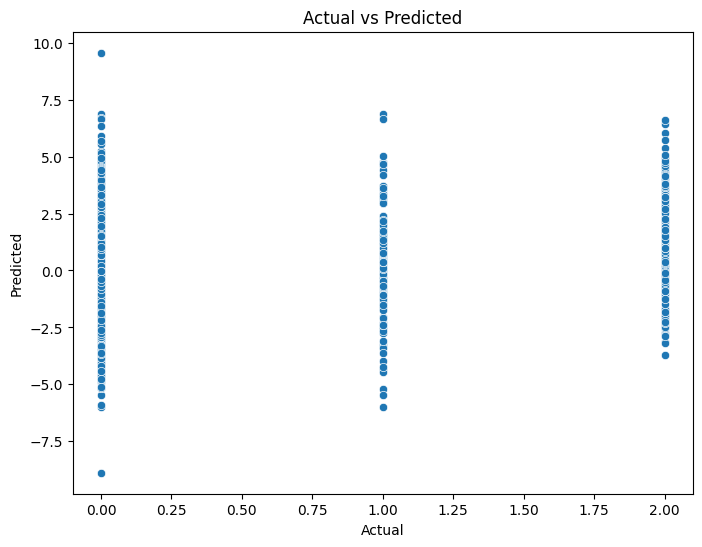

In [73]:

lr = LinearRegression(featuresCol='features', labelCol='indexed_sentiment')

train_df, test_df = df.randomSplit([0.8, 0.2], seed=69)

lr_model = lr.fit(train_df)

predictions = lr_model.transform(test_df)

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="indexed_sentiment", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

r_squared = lr_model.summary.r2
print("R-squared value:", r_squared)

pred_and_label = predictions.select("prediction", "indexed_sentiment").toPandas()
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pred_and_label, x="indexed_sentiment", y="prediction")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()


### **Applying '*Stochastic Gradient Descent* '**

In [74]:
labeled_points_rdd = df.rdd.map(lambda row: LabeledPoint(row['indexed_sentiment'], Vectors.dense(row['features'])))

train_data, test_data = labeled_points_rdd.randomSplit([0.8, 0.2], seed=123)

model = LinearRegressionWithSGD.train(train_data, iterations=100, step=0.01)

predictions_and_labels = test_data.map(lambda lp: (float(model.predict(lp.features)), lp.label))
mse = predictions_and_labels.map(lambda p: (p[0] - p[1]) ** 2).mean()
print("Mean Squared Error (MSE) = " + str(mse))

/usr/local/lib/python3.10/dist-packages/pyspark/mllib/regression.py:365: FutureWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.", FutureWarning)


Mean Squared Error (MSE) = 0.7062228330348481


### **Applying '*Naive Bayes* '**

Accuracy: 0.5391621129326047
Precision: 0.6261116501405399


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


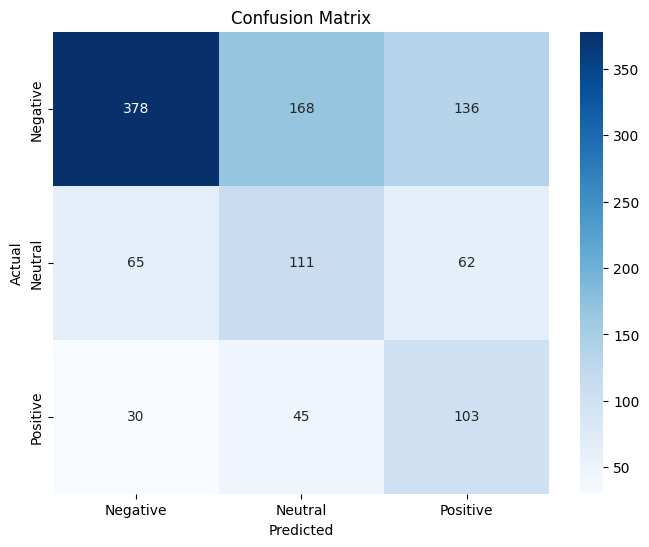

In [79]:
nb = NaiveBayes(featuresCol='features', labelCol='indexed_sentiment')

train_df, test_df = df.randomSplit([0.8, 0.2], seed=69)

nb_model = nb.fit(train_df)

predictions = nb_model.transform(test_df)

accuracy_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_sentiment", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

precision_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_sentiment", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print("Precision:", precision)

prediction_and_label = predictions.select("prediction", "indexed_sentiment").rdd.map(tuple)

metrics = MulticlassMetrics(prediction_and_label)
confusion_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [32]:
spark.stop()